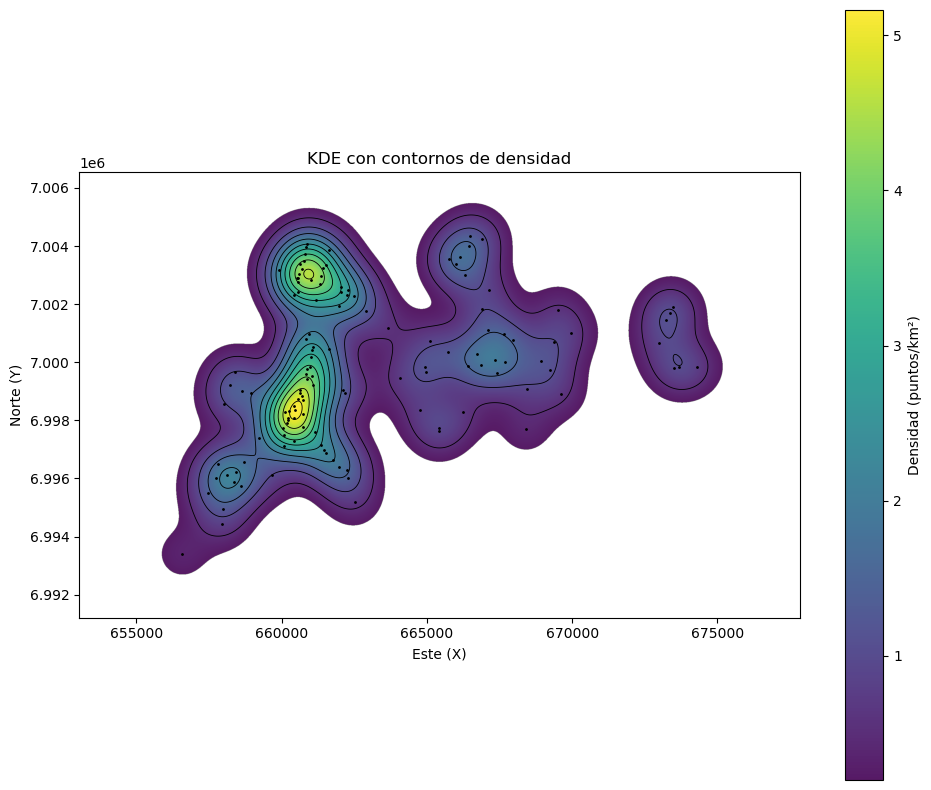

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from osgeo import gdal, osr
import os

##cargar puntos
ruta_excel = r"C:\Users\56931\Desktop\Proyecto\Distribucionpuntos.xlsx"
df = pd.read_excel(ruta_excel, sheet_name='puntos_distr')
x = df['X'].values
y = df['Y'].values

## buffer para limitar margenes en 20%
buffer_x = (x.max() - x.min()) * 0.2
buffer_y = (y.max() - y.min()) * 0.2

xmin = x.min() - buffer_x
xmax = x.max() + buffer_x
ymin = y.min() - buffer_y
ymax = y.max() + buffer_y

##resolucion
cellsize = 10  
cols = int((xmax - xmin) / cellsize)
rows = int((ymax - ymin) / cellsize)

##malla con coordenadas de sample
yy, xx = np.mgrid[ymax:ymin:-rows*1j, xmin:xmax:cols*1j]
sample_coords = np.vstack([xx.ravel(), yy.ravel()]).T

##malla de datos reales con kde gaussiano y se modifica el bandwith para variar suavizado
coords = np.vstack([x, y]).T
kde = KernelDensity(bandwidth=700, kernel='gaussian')
kde.fit(coords)
##se ingresa el sample_coords que devuelve valores en log
log_density = kde.score_samples(sample_coords)
##se aplica exp para densidad real y se aplica reshape para volver a aplicar los valores a 2D(x,y) en los rangos xx(puede ser yy)
density = np.exp(log_density).reshape(xx.shape)

## Convertir a densidad real en km2
n_puntos = len(x)
density_km2 = density * n_puntos * 1_000_000
######pixel_area=1/m2--->para pasar a km2 se *1000000

##daado que kde es densidad logaritmica se aplica a todo el espacio, por lo que se aplica filtro a valores bajos
density_masked = np.where(density_km2 < 0.2, np.nan, density_km2)  

##plot
fig, ax = plt.subplots(figsize=(10, 8))

img = ax.imshow(density_masked, origin='upper', cmap='viridis',
                extent=[xmin, xmax, ymin, ymax], alpha=0.9)

ax.contour(xx, yy, density_km2, levels=10, colors='black', linewidths=0.6)
ax.plot(x, y, 'k.', markersize=2)

ax.set_title('KDE con contornos de densidad')
ax.set_xlabel('Este (X)')
ax.set_ylabel('Norte (Y)')

cbar = fig.colorbar(img, ax=ax, label='Densidad (puntos/km²)')

plt.tight_layout()
plt.show()





In [6]:
##exportar a qgis
##Ruta
salida_tiff = r"C:\Users\56931\Desktop\Proyecto\kde_rapanui_km2.tif"

##asegura ruta de salida, si es que no esta, la crea
carpeta = os.path.dirname(salida_tiff)
if not os.path.exists(carpeta):
    os.makedirs(carpeta)

##extraccion de conversion a geootiff desde gdal; con cols, rows y 1 banda
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(salida_tiff, cols, rows, 1, gdal.GDT_Float32)

##Verificación en caso de error
if dataset is None:
    raise RuntimeError(f"No se pudo crear el archivo: {salida_tiff}")

##Geotransformación; desde xmax a xmin/ numero de columnas; en sig medida empiezas desde esquina superior derecha por eso -pixel_size_y
pixel_size_x = (xmax - xmin) / cols
pixel_size_y = (ymax - ymin) / rows 
geotransform = (xmin, pixel_size_x, 0, ymax, 0, -pixel_size_y)
dataset.SetGeoTransform(geotransform)

##Sistema de referencia; EPSG 32712 (WGS 84 / UTM zone 12S para isla de rapanui)
srs = osr.SpatialReference()
srs.ImportFromEPSG(32712)
dataset.SetProjection(srs.ExportToWkt())

##se obtiene banda 1 para colocar alli los reusltados kde, y zonas sin densidad son marcados como nan=no_data
band = dataset.GetRasterBand(1)
band.WriteArray(density_km2)
band.SetNoDataValue(np.nan) 

##termino de procesos y cierre del archivo
dataset.FlushCache()
dataset = None

print("✅ Raster KDE exportado correctamente:", salida_tiff)


✅ Raster KDE exportado correctamente: C:\Users\56931\Desktop\Proyecto\kde_rapanui_km2.tif


In [3]:
from sklearn.neighbors import NearestNeighbors
##calculo de distancias
nn = NearestNeighbors(n_neighbors=2).fit(coords)
distances, _ = nn.kneighbors(coords)
nearest_dists = distances[:, 1]  

##
nearest_mean = np.mean(nearest_dists)
nearest_min = np.min(nearest_dists)
nearest_max = np.max(nearest_dists)

##print
print(f"Distancia media al vecino más cercano: {nearest_mean:.2f} m")
print(f"Distancia mínima al vecino más cercano: {nearest_min:.2f} m")
print(f"Distancia máxima al vecino más cercano: {nearest_max:.2f} m")



Distancia media al vecino más cercano: 375.74 m
Distancia mínima al vecino más cercano: 58.22 m
Distancia máxima al vecino más cercano: 1701.88 m
